In [74]:
import numpy as np
import matplotlib.pyplot as plt


In [75]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout
from keras.layers import LSTM, CuDNNLSTM, MaxPooling1D, Conv1D, Flatten
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
from pandas import Series
from numpy.random import randn
import os
import random
import numpy as np
import time
import tensorflow as tf

In [76]:
time = np.arange(0,768,0.1);

In [77]:
time

array([0.000e+00, 1.000e-01, 2.000e-01, ..., 7.677e+02, 7.678e+02,
       7.679e+02])

In [78]:
amplitude = np.sin(time)

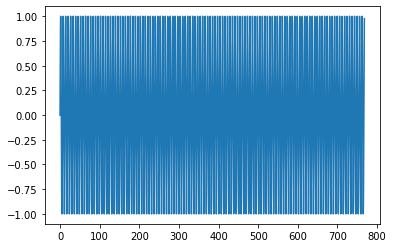

In [79]:
plt.plot(time,amplitude)

In [80]:
#using the MachineLearningMastery formula for splitting up the dataset to predictors and target
#reference: https://towardsdatascience.com/single-and-multi-step-temperature-time-series-forecasting-for-vilnius-using-lstm-deep-learning-b9719a0009de
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [81]:
# Number of lags (hours back) to use for models
lag = 256
# Steps in future to forecast 
n_ahead = 64
# ration of observations in training from total series
train_share = 0.7
val_share = 0.8
# training epochs
epochs = 10
# Batch size , which is the number of samples of lags
batch_size = 1
# Learning rate
lr = 0.001

In [82]:
data = amplitude.reshape(-1,1)

In [83]:
data.shape

(7680, 1)

In [84]:
#Scaling data between 0 and 1
scaler = MinMaxScaler()
scaler.fit(data)
ts_scaled = scaler.transform(data)

In [85]:
# Creating the X and Y for training
X, Y = create_X_Y(ts_scaled, lag=lag, n_ahead=n_ahead)

In [86]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * train_share)], Y[0:int(X.shape[0] * train_share)]
Xtest, Ytest = X[int(X.shape[0] * val_share):], Y[int(X.shape[0] * val_share):]
Xval, Yval = X[int(X.shape[0] * train_share):int(X.shape[0] * val_share)], Y[int(X.shape[0] * train_share):int(X.shape[0] * val_share)]

In [87]:
Xtrain.shape

(5152, 256, 1)

In [88]:
Xtest.shape

(1472, 256, 1)

In [89]:
Xval.shape

(736, 256, 1)

In [90]:
#Neural Network Model configuration
model = Sequential()

model.add(LSTM(32, activation='relu', input_shape=(Xtrain.shape[1], Xtrain.shape[2]), return_sequences=True))
#model.add(CuDNNLSTM(32, input_shape=(Xtrain.shape[1], Xtrain.shape[2]), return_sequences=True))
model.add(LSTM(16, activation='relu', return_sequences=False))
#model.add(CuDNNLSTM(16, return_sequences=False))
model.add(Dense(64))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0.001)
model.summary()

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics='mae')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256, 32)           4352      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                1088      
Total params: 8,576
Trainable params: 8,576
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
161/161 [==============================] - 85s 520ms/step - loss: 24.1419 - mae: 24.1419 - val_loss: 0.3034 - val_mae: 0.3034
Epoch 2/10
161/161 [==============================] - 82s 512ms/step - loss: 0.2885 - mae: 0.2885 - val_loss: 0.2045 - val_mae: 0.2045
Epoch 3/10
161/161 [==============================] - 81s 506ms/step - loss: 0.2958 - mae: 0.2958 - val_loss: 0.2763 - val_mae: 0.2763
Epoch 4/10
161/161 [==============================] - 82s 507ms/step - loss: 0.2347 - mae: 0.2347 - val_loss: 0.1644 - val_mae: 0.1644
Epoch 5/10
161/161 [==============================] - 82s 510ms/step - loss: 0.0843 - mae: 0.0843 - val_loss: 0.0291 - val_mae: 0.0291
Epoch 6/10
161/161 [==============================] - 82s 509ms/step - loss: 0.0185 - mae: 0.0185 - val_loss: 0.0131 - val_mae: 0.0131
Epoch 7/10
161/161 [==============================] - 81s 503ms/step - loss: 0.0119 - mae: 0.0119 - val_loss: 0.0102 - val_mae: 0.0102
Epoch 8/10
161/161 [==============================] -

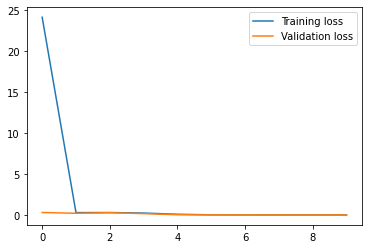

In [91]:
#Train model on train data
history = model.fit(Xtrain, Ytrain,epochs=epochs, validation_data=(Xval, Yval), shuffle=False, callbacks=[early_stopping])
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()

In [92]:
#yhat = [x[0] for x in model.predict(Xtest)]
#y = [y[0] for y in Ytest]

In [93]:
yhat = model.predict(Xtest)
yhat.shape

(1472, 64)

In [94]:
pred_n_ahead = pd.DataFrame(yhat[0])
actual_n_ahead = pd.DataFrame(Ytest[0])

In [95]:
Ytest.shape

(1472, 64)

<function matplotlib.pyplot.show>

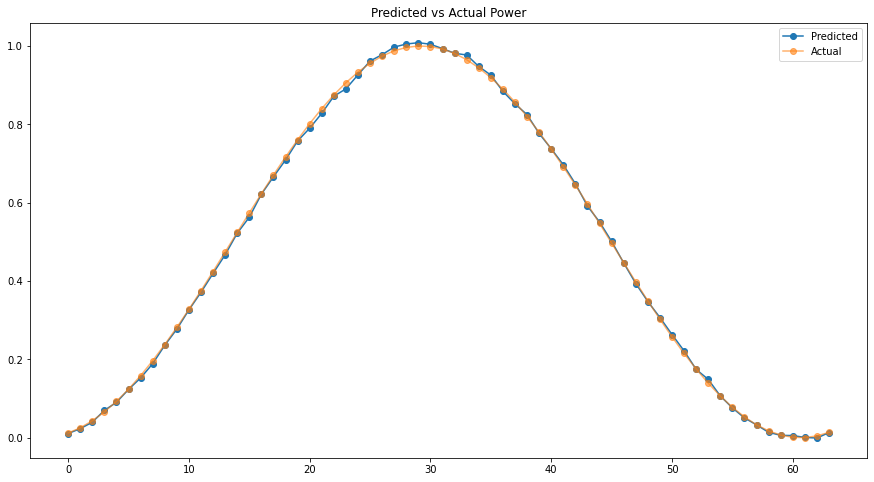

In [96]:
#plot n_steps ahead for predicted and actual data
plt.figure(figsize=(15, 8))
plt.plot(pred_n_ahead, color='C0', marker='o', label='Predicted')
plt.plot(actual_n_ahead, color='C1', marker='o', label='Actual', alpha=0.6)
plt.title('Predicted vs Actual Power')
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.legend()
plt.show

In [97]:
#evaluation metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape':mape, 'me':me, 'mae': mae,  'rmse':rmse, 
            'corr':corr})

forecast_accuracy(yhat,Ytest)

{'corr': 0.9953100983375295,
 'mae': 0.006751013478074966,
 'mape': 5.667138768386561,
 'me': -0.00201822284585368,
 'rmse': 0.00866548847146174}